# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель:*** Построить модель для определения рыночной стоимости автомобиля

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных:**

Признаки  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
Repaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  

Целевой признак:    
Price — цена (евро)

## 1. Загрузка данных

In [1]:
!pip install phik

     |████████████████████████████████| 679 kB 1.7 MB/s eta 0:00:01


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(palette='pastel')

import lightgbm as lgb

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder 
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from time import time

Загрузим файл с данными:

In [3]:
df = pd.read_csv('/datasets/autos.csv').copy()

Для вывода информации о файле создадим функцию `info_df`

In [4]:
def info_df(df):
    display(df.info())
    display(df.head())
    display(df.describe())
    df.hist(figsize=(16,14))
    plt.show()
    return

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


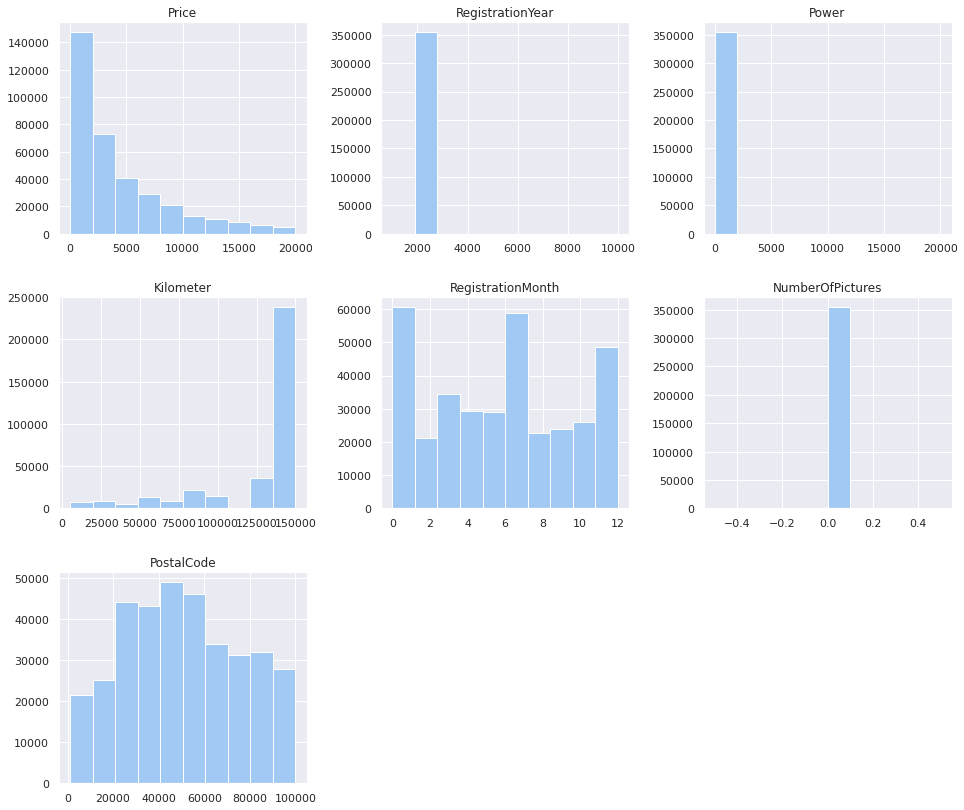

In [5]:
info_df(df)

Проверим корреляцию признаков. Предварительно создадим функцию `phik`

In [6]:
def phik(df):
    phik_overview = df.phik_matrix()
    plot_correlation_matrix(phik_overview.values, 
                            x_labels=phik_overview.columns, 
                            y_labels=phik_overview.index, 
                            vmin=0, vmax=1, color_map="Greens", 
                            title='Матрица корреляции Phik', 
                            fontsize_factor=1.4, 
                            figsize=(18, 18))
    plt.tight_layout()
    return

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']


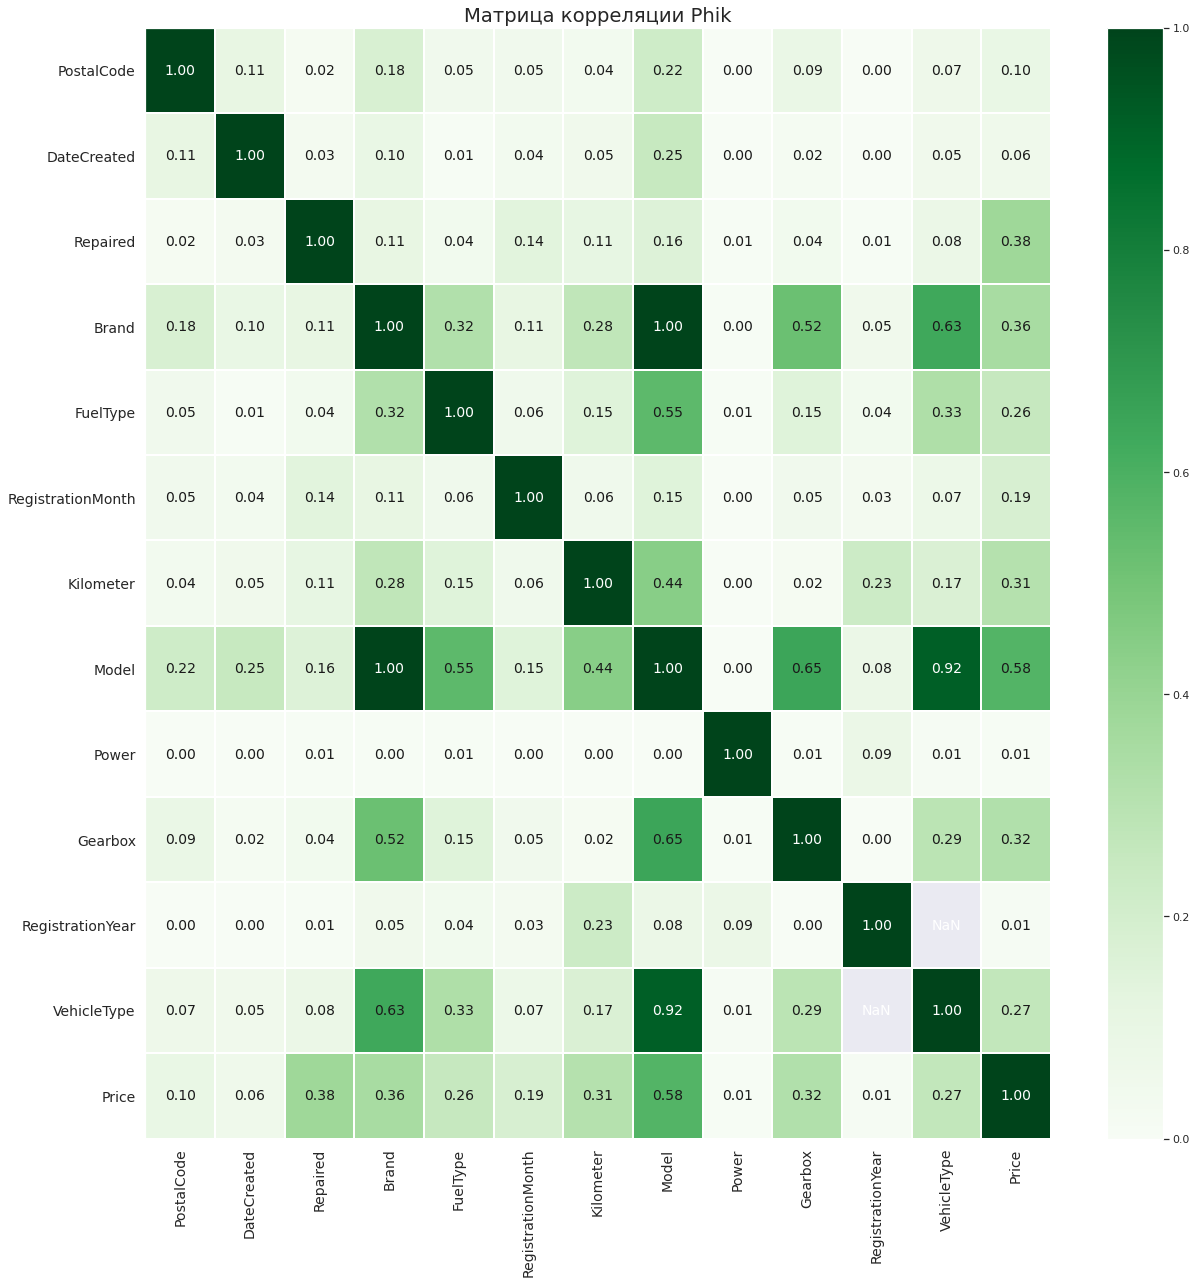

In [7]:
phik(df.drop(['DateCrawled', 'LastSeen', 'NumberOfPictures'], axis=1))

**Вывод:**  
- Типы данных не соответствуют содержимому по признакам DateCrawled, LastSeen, DateCreated;  
- Наличие пропусков в данных;  
- Наличие выбросов в данных;  
- Наличие корреляции независимых признаков в целевым. Мультиколлениарность независимых признаков.

## 2. Предобработка данных

### 2.1 Наименование столбцов 

Приведем наименование столбцов к 'змеиному регистру': 

In [8]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [9]:
df = df.rename(columns={'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type',\
                        'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox', 'Power': 'power',\
                        'Model': 'model', 'Kilometer': 'kilometer', 'RegistrationMonth': 'registration_month',\
                        'FuelType': 'fuel_type', 'Brand': 'brand', 'Repaired': 'repaired',\
                        'DateCreated': 'date_created', 'NumberOfPictures': 'number_of_pictures',\
                        'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### 2.2 Приведение типов данных

Ппреобразуем данные по признакам 'date_crawled', 'last_seen', 'date_created' в формат datetime

In [10]:
df[['date_crawled', 'last_seen', 'date_created']] = df[['date_crawled', 'last_seen', 'date_created']].apply(pd.to_datetime)#, format='%Y.%m.%d')
df.dtypes['last_seen']

dtype('<M8[ns]')

Колонки с типом данных int64 приведем к типу int16

In [11]:
df[['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'number_of_pictures',\
    'postal_code']] = df[['price', 'registration_year', 'power', 'kilometer', 'registration_month',\
                          'number_of_pictures', 'postal_code']].astype('int16')
df.dtypes['price']

dtype('int16')

### 2.3 Дубликаты

Проверим на явные дубликаты:

In [ ]:
df.drop(['Unnamed: 0'], axis=1).duplicated().sum()

In [13]:
df = df.drop_duplicates()

In [14]:
df.duplicated().sum()

0

Проверим уникальные значения в категориальных признаках:

'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'

**vehicle_type:**

In [15]:
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

**gearbox:**

In [16]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

**model:**

In [17]:
df['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

**fuel_type:**

In [18]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Заменим значение 'gasoline' на значение 'petrol', так как оба значения являются типом топлива - бензин:

In [19]:
df['fuel_type'] = df['fuel_type'].str.replace('gasoline', 'petrol')
df['fuel_type'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

**brand:**

In [20]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

Проверим уникальные значения для брендов 'rover' и 'land_rover':

In [21]:
(df[df['brand'] == 'rover']['model']).unique()

array(['other', 'discovery', nan, 'rangerover', 'freelander', 'defender'],
      dtype=object)

In [22]:
(df[df['brand'] == 'land_rover']['model']).unique()

array(['discovery', 'freelander', 'defender', nan, 'range_rover',
       'serie_2', 'range_rover_sport', 'other', 'range_rover_evoque',
       'serie_3', 'serie_1'], dtype=object)

Так как уникальные значения моделей совпадают, заменим 'rover' на 'land_rover':

In [23]:
df['brand'] = df['brand'].str.replace('land_rover', 'rover')
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'lada'], dtype=object)

**repaired:**

In [24]:
df['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

### 2.4 Обработка пропущенных значений

In [25]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Пропущенные значения в данных заменим значением 'unknown':

In [26]:
df[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']] = df[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']].fillna('unknown')
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

### 2.5 Обработка аномальных значений

Аномальные значения присутствую в признаках price, registration_year, registration_month, power, kilometer, postal_code. Проведем обработку аномальных значений:

In [27]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,12092.072840,5.714650,0.0,3132.429255
std,4514.176349,90.228466,189.851330,13977.716566,3.726432,0.0,19502.386710
min,0.000000,1000.000000,0.000000,-31072.000000,0.000000,0.0,-32745.000000
25%,1050.000000,1999.000000,69.000000,14464.000000,3.000000,0.0,-14393.000000
50%,2700.000000,2003.000000,105.000000,18928.000000,6.000000,0.0,5727.000000
75%,6400.000000,2008.000000,143.000000,18928.000000,9.000000,0.0,21220.000000
max,20000.000000,9999.000000,20000.000000,30000.000000,12.000000,0.0,32760.000000


**price:**

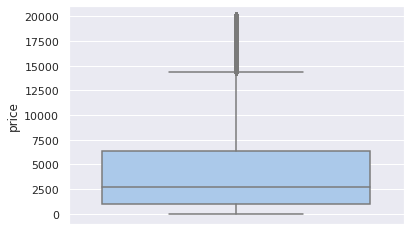

In [28]:
sns.boxplot(y=df['price'])
plt.show()

По признаку присутствуют нулевые значения и выбросы свыше 15000. Так как признак является целевым, нулевые значения исключаем. Выбросы свыше 15000 оставляем, так как могут быть значимыми:

In [29]:
df = df[df['price'] > 1]

**registration_year:**

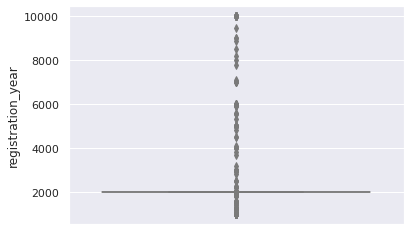

In [30]:
sns.boxplot(y=df['registration_year'])
plt.show()

In [31]:
df[df['registration_year'] > 2023]['registration_year'].count()

82

In [32]:
df[df['registration_year'] < 1900]['registration_year'].count()

49

Исключим значения registration_year старше 2023 года и младше 1900:

In [33]:
(df['date_crawled']).max()

Timestamp('2016-04-07 14:36:58')

In [34]:
df = df[df['registration_year'] < 2017]

In [35]:
df = df[df['registration_year'] > 1900]

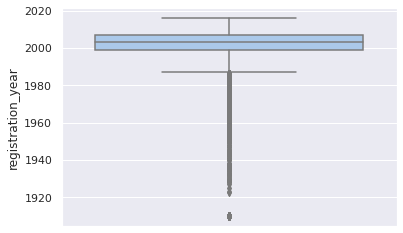

In [36]:
sns.boxplot(y=df['registration_year'])
plt.show()

**power:**

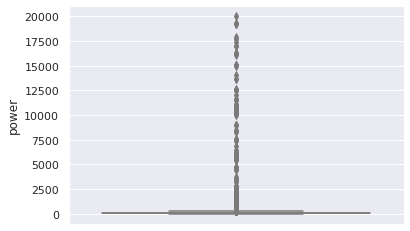

In [37]:
sns.boxplot(y=df['power'])
plt.show()

Исключим значения свыше 700 лс:

In [38]:
df[df['power'] > 700]['power'].count()

300

In [39]:
df = df[df['power'] < 700]

In [40]:
df = df[df['power'] >= 4]

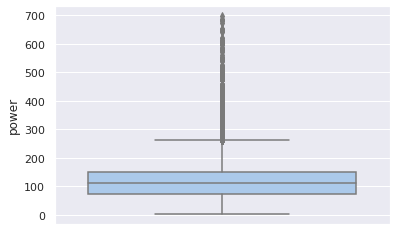

In [41]:
sns.boxplot(y=df['power'])
plt.show()

**kilometer:**

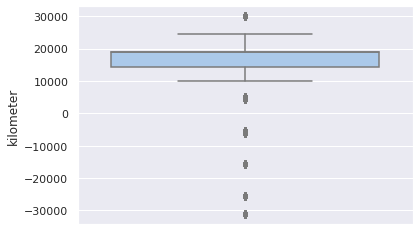

In [42]:
sns.boxplot(y=df['kilometer'])
plt.show()

По признаку присутствуют отрицательные значения и выбросы свыше 20000. По отрицательным значениям возьмем модуль чисел, выбросы свыше 20000 оставим без изменений:

In [43]:
df['kilometer'] = df['kilometer'].abs()

## 3. Исследовательский анализ данных

С целевым признаком имеют наибольшую корреляцию следующие независимые признаки:  
- model - 0.57;  
- repaired - 0.37;  
- brand - 0.33;  
- gearbox - 0.31;  
- vehicle_type - 0.28;  
- kilometer - 0.27;  
- fuel_type - 0.26;
- registration_month - 0.19.  
Рассмотрим зависимость целевого от приведенных выше признаков, так же рассмотрим признак registration_year и power: 

**registration_year:**

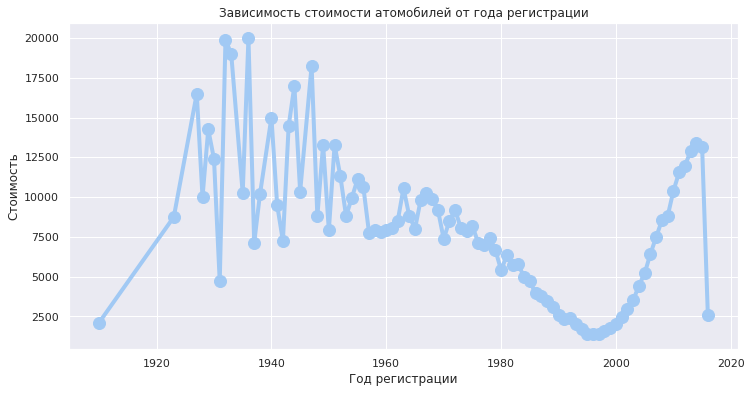

In [44]:
dynamic_by_year = df.groupby('registration_year')['price'].agg('mean')
dynamic_by_year = dynamic_by_year[dynamic_by_year.index > 0]
dynamic_by_year.plot(y=['price'], figsize=(12,6), grid=True, marker='o', linewidth=4, markersize=12)
plt.title('Зависимость стоимости атомобилей от года регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Стоимость')
plt.show()

Вывод: Наибольшую стоимость имеют автомобили зарегистрированные в период 2016-2017 года, наименьшую в 1994-1996. Стоит отметить высокую стоимость раритетных автомобилей зарегистрированнных в период 1930-1960.

**registration_month:**

Данный признак имеет аномальное значение 0. Предположим, что 0 обозначет неопределенные месяц регистрации. Исключим даный месяц из анализа: 

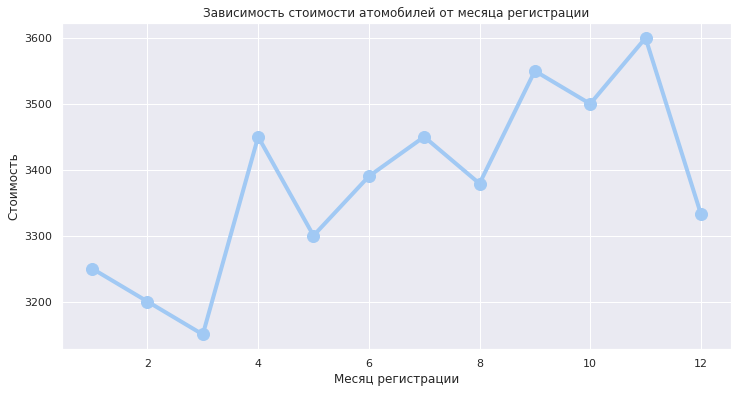

In [45]:
dynamic_by_month = df.groupby('registration_month')['price'].agg('median')
dynamic_by_month = dynamic_by_month[dynamic_by_month.index > 0]
dynamic_by_month.plot(y=['price'], figsize=(12,6), grid=True, marker='o', linewidth=4, markersize=12)
plt.title('Зависимость стоимости атомобилей от месяца регистрации')
plt.xlabel('Месяц регистрации')
plt.ylabel('Стоимость')
plt.show()

Вывод: минимальная стоимость автомобилей наблюдается в марте. Наибольшая  - с  сентября по ноябрь.

**model и brand:**

С учетом коллинеарности признаков, рассмотрим только brand:

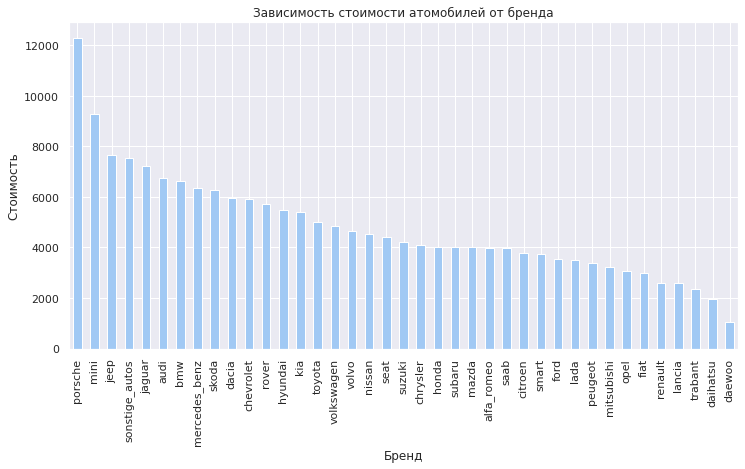

In [46]:
dynamic_by_brand = df.groupby('brand')['price'].agg('mean').sort_values(ascending=False)
dynamic_by_brand.plot(y=['price'], figsize=(12,6), kind='bar')
plt.title('Зависимость стоимости атомобилей от бренда')
plt.xlabel('Бренд')
plt.ylabel('Стоимость')
plt.show()

Вывод: Наибольшую стоимость имеют автомобили бренда Porsche, наименьшую - daewoo.

**repaired**

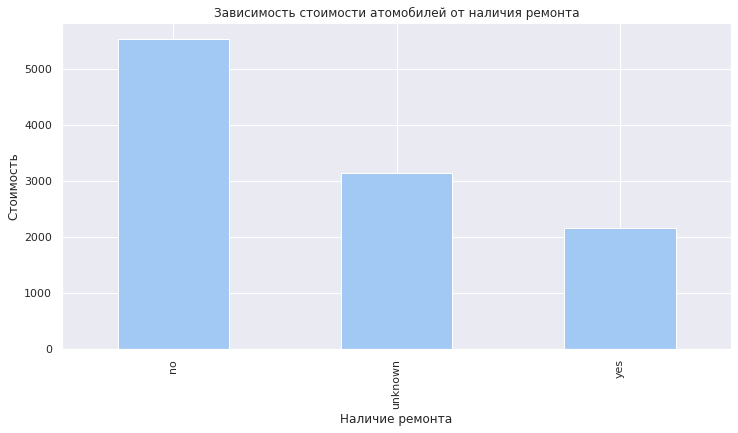

In [47]:
df.groupby('repaired')['price'].agg('mean').plot(y=['price'], figsize=(12,6), kind='bar')
plt.title('Зависимость стоимости атомобилей от наличия ремонта')
plt.xlabel('Наличие ремонта')
plt.ylabel('Стоимость')
plt.show()

Вывод: Наибольшую стоимость имеют автомобили не бывшие в ремонте.

**gearbox**

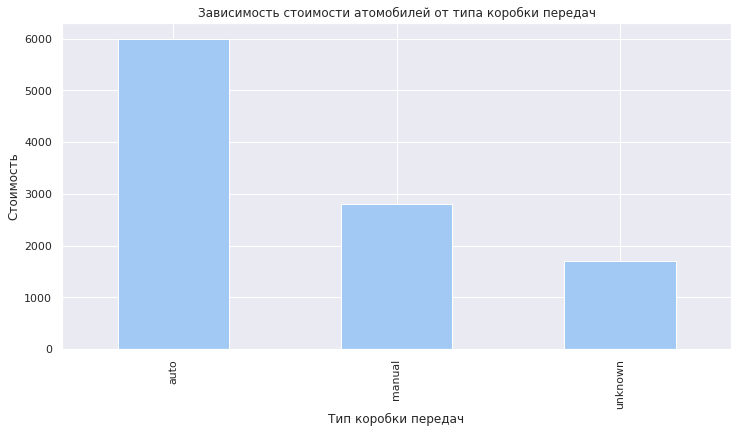

In [48]:
df.groupby('gearbox')['price'].agg('median').plot(y=['price'], figsize=(12,6), kind='bar')
plt.title('Зависимость стоимости атомобилей от типа коробки передач')
plt.xlabel('Тип коробки передач')
plt.ylabel('Стоимость')
plt.show()

Вывод: Наибольшую стоимость имеют автомобили c атоматической коробкой передач.

**vehicle_type**

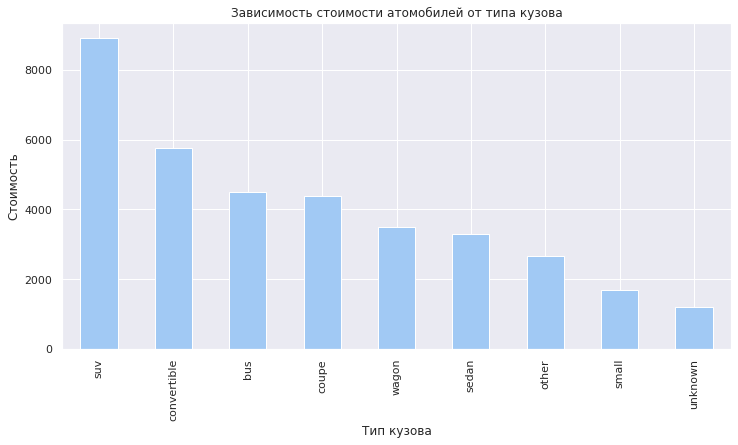

In [49]:
df.groupby('vehicle_type')['price'].agg('median').sort_values(ascending=False).plot(y=['price'], figsize=(12,6), kind='bar')
plt.title('Зависимость стоимости атомобилей от типа кузова')
plt.xlabel('Тип кузова')
plt.ylabel('Стоимость')
plt.show()

Вывод: наибольшую стоимость имеют автомобили с типом кузова - кроссовер.

**fuel_type**

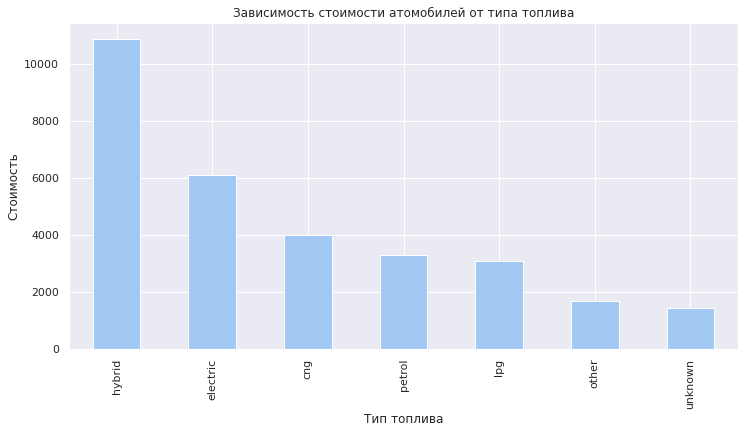

In [50]:
df.groupby('fuel_type')['price'].agg('median').sort_values(ascending=False).plot(y=['price'], figsize=(12,6), kind='bar')
plt.title('Зависимость стоимости атомобилей от типа топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Стоимость')
plt.show()

Вывод: наибольшую стоимость автомобилей имеют автомобили с гибридным типом топлива

**kilometer**

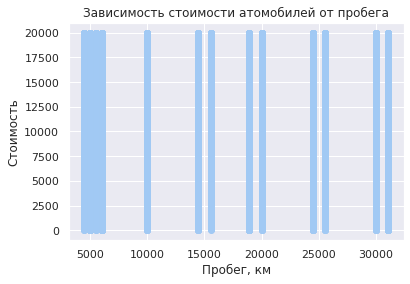

In [51]:
plt.plot('kilometer', 'price', data=df, linestyle='none', marker='o')
plt.title('Зависимость стоимости атомобилей от пробега')
plt.xlabel('Пробег, км')
plt.ylabel('Стоимость')
plt.show()

Вывод: значительного влияния на стоимоть автомобиля не имеет

**power**

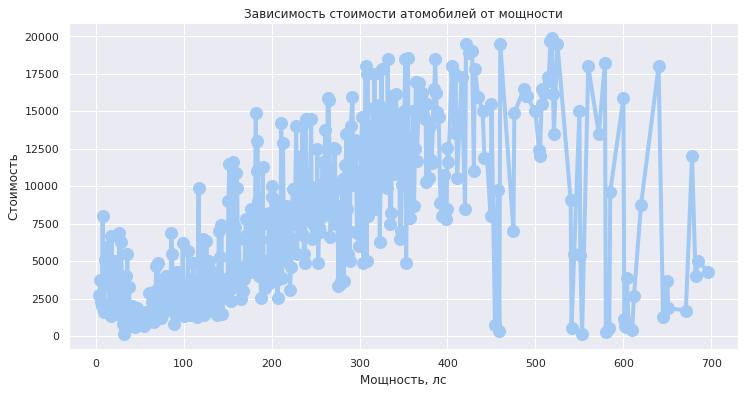

In [52]:
dynamic_by_power = df.groupby('power')['price'].agg('median')
dynamic_by_power = dynamic_by_power[dynamic_by_power.index > 0]
dynamic_by_power.plot(y=['price'], figsize=(12,6), grid=True, marker='o', linewidth=4, markersize=12)
plt.title('Зависимость стоимости атомобилей от мощности')
plt.xlabel('Мощность, лс')
plt.ylabel('Стоимость')
plt.show()

Вывод: Наибольшую стоимость имеют автомобили с мощностью более 400лс, наименьшую от 40 до 60 лс.

## 4. Разработка моделей машинного обучения

Для обучения моделей будем использовать два алгоритма:  
- градиентный бустинг;
- случайный лес.  
Для оценки качества прогнозирования используем метрику RMSE. При выборе лучшей модели также учитываем скорость обучения и скорость прогнозирования.

### 4.1 Подготовка признаков

По результатам исследовательского анализа данных и матрицы корреляции сформируем наборы признаков:

In [53]:
X_train = df[['model', 'repaired', 'gearbox', 'kilometer', 'registration_month', 'registration_year', 'power', 'vehicle_type', 'fuel_type']].reset_index(drop=True)
y_train = df['price'].reset_index(drop=True)

ordinal encoder

In [60]:
RANDOM_STATE = 25
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25,\
                                                            random_state=RANDOM_STATE)
X_train.shape

(221922, 9)

In [61]:
encoder = OrdinalEncoder()
X_train_enc = X_train.copy()
X_train_enc[X_train_enc.select_dtypes(include=['object']).columns] = \
                    pd.DataFrame(encoder.fit_transform(X_train_enc[X_train_enc.select_dtypes(include=['object']).columns]),\
                    index=X_train_enc.index)

In [62]:
X_test_enc = X_test.copy()
X_test_enc[X_test_enc.select_dtypes(include=['object']).columns] = \
                    pd.DataFrame(encoder.transform(X_test_enc[X_test_enc.select_dtypes(include=['object']).columns]),\
                    index=X_test_enc.index)

### 4.2 Обучение моделей и подбор параметров

#### 4.2.1 Градиентный бустинг

In [63]:
lgb_model = LGBMRegressor(random_state=RANDOM_STATE)
lgb_grid_params = [{'n_estimators': [20, 40, 60], 
                    'learning_rate':[0.01, 0.1, 0.2]}]
lgb_cv = GridSearchCV(estimator=lgb_model, param_grid=lgb_grid_params, cv=3, scoring='neg_mean_squared_error')

lgb_cv.fit(X_train_enc, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=25),
             param_grid=[{'learning_rate': [0.01, 0.1, 0.2],
                          'n_estimators': [20, 40, 60]}],
             scoring='neg_mean_squared_error')

In [64]:
lgb_cv.best_params_

{'learning_rate': 0.2, 'n_estimators': 60}

Результаты GridSearchCV сохраним в lgb_results:

In [67]:
lgb_results = pd.DataFrame(lgb_cv.cv_results_)

#### 4.2.2 Случайный лес

In [69]:
rfr_model = RandomForestRegressor(random_state=RANDOM_STATE)

rfr_grid_params = [{'rfr__max_depth': range (6, 20, 2),
              'rfr__min_samples_leaf': range (2,6)              
              }]
 
pipeline = Pipeline([('scaler',StandardScaler()), ('rfr', rfr_model)])
rfr_cv = GridSearchCV(estimator=pipeline,  
                    param_grid=rfr_grid_params,
                    scoring='neg_mean_squared_error',
                    cv=3)

rfr_cv.fit(X_train_enc, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rfr',
                                        RandomForestRegressor(random_state=25))]),
             param_grid=[{'rfr__max_depth': range(6, 20, 2),
                          'rfr__min_samples_leaf': range(2, 6)}],
             scoring='neg_mean_squared_error')

In [70]:
rfr_cv.best_params_

{'rfr__max_depth': 18, 'rfr__min_samples_leaf': 2}

Результаты GridSearchCV сохраним в rfr_results:

In [74]:
rfr_results = pd.DataFrame(rfr_cv.cv_results_)

## 5. Анализ моделей

Для анализа моделей по лучшим параметрам, создадим таблицу с временем обучением, временем предсказания и полученнной метрикой качества на тестовой выборке:

In [75]:
results = pd.DataFrame(columns=['Модель', 'Время обучения, с', 'Время предсказания, с', 'RMSE'])

### 5.1 Тестирование модели

In [79]:
results = results.append({'Модель': 'LGBMRegressor',\
                          'Время обучения, с': lgb_results[lgb_results['rank_test_score'] == 1]['mean_fit_time'].values[0], \
                          'Время предсказания, с': lgb_results[lgb_results['rank_test_score'] == 1]['mean_score_time'].values[0],
                          'RMSE': ((lgb_results[lgb_results['rank_test_score'] == 1]['mean_test_score'].values[0])* -1 )**0.5},\
                                 ignore_index=True)

In [80]:
results = results.append({'Модель': 'RandomForestRegressor',\
                                 'Время обучения, с': rfr_results[rfr_results['rank_test_score'] == 1]['mean_fit_time'].values[0], \
                                 'Время предсказания, с': rfr_results[rfr_results['rank_test_score'] == 1]['mean_score_time'].values[0],
                                 'RMSE': ((rfr_results[rfr_results['rank_test_score'] == 1]['mean_test_score'].values[0])* -1 )**0.5},\
                                  ignore_index=True)

In [81]:
results

,Модель,"Время обучения, с","Время предсказания, с",RMSE
0,LGBMRegressor,2.437719,0.371449,1743.651552
1,RandomForestRegressor,28.403864,1.642639,1676.280991


**Анализ:** 
Лучшее время обучения у модели - LGBMRegressor;  
Лучшее время предсказания - LGBMRegressor;  
Наилучшая точность предсказания - RandomForestRegressor.  

С учетом требования заказчика, для решения данной задачи можно порекомендовать модель LGBMRegressor. Данная модель уступает RandomForestRegressor в качестве предсказаний на 1%, но значительно превосходит по временным показателям

Проведем тестирование модели:

In [98]:
best_model = lgb_cv.best_estimator_
predict = best_model.predict(X_test_enc)
RMSE = mean_squared_error(y_test, predict) ** 0.5
RMSE

1766.4043501576214

На тестовой выборке модель показала незначительное ухудшение качества предсказания на 1%

### 5.2 Значимость признаков

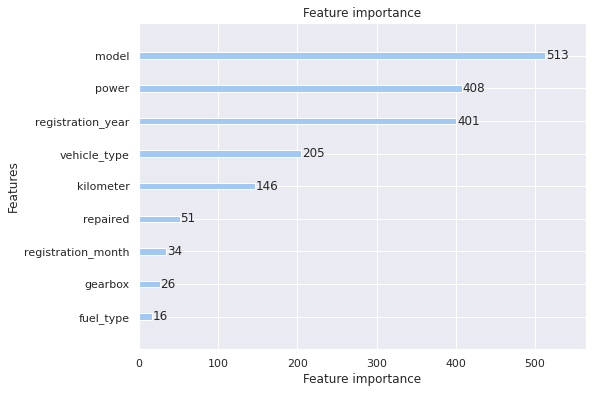

In [95]:
lgb.plot_importance(best_model, figsize=(8,6));

**Вывод:** наиболее значимые признаки для модели по алгоритму LGBMRegressor:  
- model;  
- power;  
- registration_year.

## 6. Общий вывод

В ходе выполнения работы был проведена предобработка данных, исследовательский анализ, разработано две модели машинного обучения, проанализированны временные показатели обучения и предсказания моделей и проведен анализ значимости признаков для лучшей модели.

Наилучшее качество предсказаний и время обучения получили у модели по алгоритму 'градиентный бустинг'. Наилучшее качество предсказаний имеет модель на основе алгоритма 'случайный'. С учетом важности метрик качества для заказчика, рекомендуемой моделью является модель на основе 'градиентного бустинга'.  

Наиболее важные признаки для лучшей модели: модель, мощность двигателя и год регистрации автомобиля.